# Support Vector Machines

In [7]:
# PREAMBLE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cvxopt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

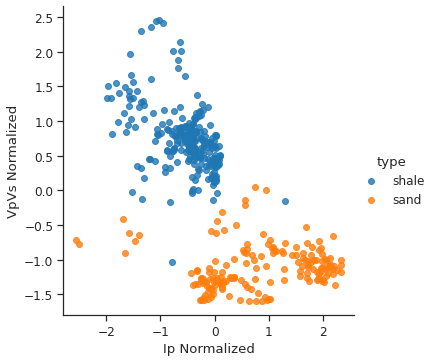

In [8]:
# load rock types data set
df = pd.read_csv('/rocktypes.csv', sep=' ')
#df['Ip Normalized'] = 2*(df['Ip'] - df['Ip'].min())/(df['Ip'].max()- df['Ip'].min()) -1
#df['VpVs Normalized'] = 2*(df['VpVs'] - df['VpVs'].min())/(df['VpVs'].max()- df['VpVs'].min()) -1
sns.lmplot(x='Ip Normalized', y='VpVs Normalized', hue='type', data=df, fit_reg=False)

In [9]:
# export pandas dataframe to numpy array
X = df[['Ip Normalized','VpVs Normalized']].values 

y = df['label'].values
(n,d) = X.shape

print(f"Dimensions X: {X.shape}, y: {y.shape}")

Dimensions X: (431, 2), y: (431,)


### Squared Exponential Kernel

To find non-linear decision boundaries with the SVM, we need to first implement
a kernel function. You can think of the squared exponential kernel as a similarity function that measures the "distance" between a pair of examples, $(x, z)$ with $x,z\in\mathbb{R}^d$. The squared exponential kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to $0$) as the instances are further apart. 

The squared exponential kernel function is defined as

$$
k(x,z) = \exp \Big( -\frac{\lVert x-z\rVert^2}{2\sigma^2} \Big)
$$

You should now complete the code in `SEKernel` to compute
the squared exponential kernel between two examples, ($x_{i}$, $x_{j}$) simply called `x` and `z` in the function.

In [10]:
def SEKernel(x, z, sigma):
    return np.exp(      -1 *  np.power(np.linalg.norm(x-z),2) /(2*sigma*sigma)    )   

In [11]:
# test the kernel function
x = np.array([1, 2,  1])
z = np.array([0, 4, -1])

sigma = 2
sim = SEKernel(x, z, sigma)

print(f'''squared exponential kernel between
\tx = [1; 2;  1]
\tz = [0; 4; -1]
with sigma = {sigma:.2f} is {sim:.3f} (this value should be about 0.324652)\n''')

np.testing.assert_array_almost_equal(SEKernel(x, z, sigma=2).squeeze(),[0.324],decimal=2) 

squared exponential kernel between
	x = [1; 2;  1]
	z = [0; 4; -1]
with sigma = 2.00 is 0.325 (this value should be about 0.324652)



Now implement a vectorized version of `SEKernel` such that it returns the Gram matrix (sometimes also called a "kernel matrix"), $K\in \mathbb{R}^{n\times m}$ with

$$
K_{ij} = k(x_{i}, z_{j})
$$

where $x_{i}$ is the $i$th row in $X$ and $z_{j}$ is the $j$th row in $Z$.

In [12]:
def sqdist(X, Z):

    res = np.zeros((len(X),len(Z)))
    for i in range(len(X)):
      for j in range(len(Z)):
        res[i][j]= np.sum(np.square(X[i]-Z[j]))

    return res

In [13]:
def SEKernelVec(X, Z, sigma):
    K = np.exp(- sqdist(X,Z)/ (2*sigma*sigma))
    return K

In [14]:
# test the vectorized gaussianKernel
rng = np.random.RandomState(2)
XX = rng.rand(3,2)
ZZ = rng.rand(2,2)
K = np.array([[ 0.44,  0.86],[ 0.74,  0.83],[ 0.77,  0.96]])
np.testing.assert_array_almost_equal(SEKernelVec(XX, ZZ, sigma=.5),K,decimal=2) 

## SVM Dual Form

Recall the primal support vector machine optimization problem:
$$
\begin{align}
\min_{w,b}\quad & \lVert w \rVert^2 + C \sum_{i=1}^n \xi_i \\
\text{s.t.}\quad & y_i(w^Tx_i + b) \geq 1 - \xi_i\\
& \xi_i \geq 0
\end{align}
$$

We can form the Lagrangian:
$$
\mathcal{L}(w,b,\xi,\alpha,\gamma) = \frac{1}{2}w^Tw + C\sum_{i=1}^n \xi_i - \sum_{i=1}^n\alpha_i[y_i(x_i w+b) -w +\xi_i] - \sum_{i=1}^n\gamma_i\xi_i
$$

Here, the $\alpha_i$'s and $\gamma_i$'s are our Lagrange multipliers (constrained to be $\geq 0$).

After setting the derivatives with respect to w and b to zero as before, substituting
them back in, and simplifying, we obtain the following dual form of the
problem:

$$
\begin{align}
\max_{\alpha} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j \langle x_i, x_j \rangle \\
\text{s.t.}\quad & 0\leq \alpha_i\leq C\\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align}
$$

We have that $w$ can be expressed in terms of the $\alpha_i$'s given by
$$
w = \sum_{i=1}^n \alpha_i y_i x_i,
$$
so that after solving the dual problem, we can use
$$
f(x) = w^Tx+b = \sum_{i=1}^n \alpha_i y_i \langle x_i, x \rangle +b
$$
to make our predictions.

Since the algorithm can be written entirely in terms of the inner products
$\langle x, z \rangle$, this means that we would replace all those inner products with
$\langle \phi(x), \phi(z) \rangle$. Specificically, given a feature mapping $\phi$, we define the corresponding
Kernel to be

$$
k(x, z) = \langle \phi(x), \phi(z) \rangle.
$$

Then, everywhere we previously had $\langle x, z \rangle$ in our algorithm, we could simply
replace it with $k(x, z)$, and our algorithm would now be learning using the
features $\phi$.

## Solving the svm dual optimization problem with Quadratic Programming

The SVM dual problem can be optimized by quadratic programming. You need to download and install a third party library called "cvxopt".

Quadratic programming is a general optimization routine to find a minimum for a problem specified by
$$
\begin{align}
\min_x\quad& \frac{1}{2} x^TPx + q^Tx\\
\text{s.t.}\quad & Gx \leq h\\
& Ax = b
\end{align}
$$
and we have to bring the SVM dual into this form.

In [15]:
# wrapper around cvxopt
def quadprog(P,q,G,h,A,b):
    sol = cvxopt.solvers.qp(cvxopt.matrix(P), 
                      cvxopt.matrix(q), 
                      cvxopt.matrix(G), 
                      cvxopt.matrix(h), 
                      cvxopt.matrix(A), 
                      cvxopt.matrix(b))
    return np.ravel(sol['x'])

#### The Quadratic Program
We write the SVM optimization problem as a Quadratic Program.
Let $K$ be the Gram matrix with $K_{i,j} = k(x_i,x_j)$ then

$$
\begin{align}
P & = yy^T \circ K\\
q & = [-1, -1, -1, \dotsc, -1]\\
G & = [-I, I]^T\\
h & = [0, 1\cdot C]^T\\
A & = y\\
b & = 0
\end{align}
$$

where $I$ is the identity matrix of size $n\times n$.

The function `lagrange_multipliers` below calculates these quantities and calls `quadprog` to obtain the $\alpha$'s.

In [37]:
def lagrange_multipliers(X, y, C, K):
    n = X.shape[0]
    P = y*y.T*K
    q = np.ones(n)
    q = -1*q
    I = np.identity(n)
    G = np.vstack((-I,I))
    G = G.T
    h = np.vstack((0 , 1*C)).T
    A =y
    b=0


    return quadprog(P,q,G,h,A,b)   

The optimal bias $b$ can be determined by KKT dual-complementarity conditions which quarantees that
$$
y_i (w^Tx_i + b) = 1 \quad\text{if}\quad 0 < \alpha_i < C
$$
and hence
$$
\begin{align}
y_i (w^Tx_i + b) &= 1\\
w^Tx_i + b &= y_i\\
b &= y_i - w^Tx_i\\
&= y_i - \sum_{j=1}^n \alpha_j y_j k(x_j, x_i)
\end{align}
$$
for any $0 < \alpha_i < C$.

Implement the function `bias` below which returns $b$.

In [17]:
def bias(X, y, C, alpha, K):
    b = y - alpha*y*K
    return b

We now have function to calculate $\alpha$ and $b$. This allows us to implement the support vector machine. 
The function `svm_learn` below first computes $\alpha$ and $b$ and then returns a function 
$$
z\mapsto \sum_{i=1}^n \alpha_i y_i k(x_i, z) +b
$$
which is able to make predictions for new data point $z$.

In [25]:
def svm_learn(X,y,C,kernel):
    K = kernel(X, X)
    alpha = lagrange_multipliers(X,y,C,K)   # obtain lagrange multiplier 
    b = bias(X,y,C,alpha,K)                 # calculate bias
    
    # select support vectors.
    sidx = alpha > 1e-5
    SVs = X[sidx, :]    
    
    # SVM classification function
    def f(Z):
        K = kernel(SVs, Z) # compute kernel matrix
        beta = np.diag(alpha[sidx]*y[sidx])
        return np.sum(np.dot(beta,K),axis=0) + b

    return f

In [38]:
# Plotting decision regions
def plot_desicion_boundary(X, y, clf):
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    x_enlarge = (x_max-x_min)*0.1
    y_enlarge = (y_max-y_min)*0.1
    xx, yy = np.meshgrid(np.linspace(x_min-x_enlarge, x_max+x_enlarge, 25),np.linspace(y_min-y_enlarge, y_max+y_enlarge, 25))
    XX = np.c_[xx.ravel(), yy.ravel()]
    Z = clf(XX).reshape(xx.shape) 
    cmap = sns.diverging_palette(275, 10, as_cmap=True)
    plt.contourf(xx, yy, Z, alpha=.2, cmap=cmap, levels=np.linspace(Z.min(),Z.max(),20))
    plt.contour(xx, yy, Z, levels=[0.0,0.1])

    
    
# learn the support vector machine
sigma = 1.0
C = 1
kernel = lambda X, Y: SEKernelVec(X, Y, sigma)
svm = svm_learn(X, y, C, kernel)

# load rock types data set
df = pd.read_csv('/rocktypes.csv', sep=' ')
sns.lmplot(x='Ip Normalized', y='VpVs Normalized', hue='type', data=df, fit_reg=False) 
plot_desicion_boundary(X, y, svm)

TypeError: ignored